In [ ]:
import chime, warnings,time
chime.notify_exceptions()
warnings.filterwarnings('ignore')

# Required Dependencies for the whole notebook

In [ ]:
# Data Science basic imports
import pandas as pd, numpy as np, seaborn as sb, matplotlib.pyplot as plt, matplotlib.dates as mdates
# ML Data Preprocessing imports
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import LabelEncoder, StandardScaler # Z-Score
from sklearn.linear_model import LinearRegression, LogisticRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Business Understanding - Data Understanding - Data Preparation - EDA

<img src = 'datasc-660x434.png'>

# Regression Problem

The business problem is understanding the COVID-19.The cumulative count of confirmed, death and recovered cases of COVID-19 from different countries from 22nd January 2020
1. Collecting data https://www.kaggle.com/datasets/imdevskp/corona-virus-report?select=covid_19_clean_complete.csv
- [Note: the downloaded file is in .zip, we need to unzip it then import it as csv]
2. Understanding the data by using the traditional Python data science modules. 

In this notebook, we will walkthrough the pandas library which is used for data wrangling tasks: data assessing, data coding and data cleaning. This is a part of business & data understanding and preparation. [Note: Best practice is always to import os module along with numpy]

- Importing data and dealing with data with different formats: CSV, JSON, TSV, XLSX, TXT, HTML and etc ...
  - pd.read_csv('FILENAME.CSV')
  - pd.read_excel('FILENAME.XLSX',sheet = n) # where n is the sheet number 
- Functions and command to assess the data
  - head(n): Finding n top rows
  - tail(n): Finding n bottom rows
  - sample(n): Finding n sample of data
  - info(): get an overall information about the data attributes/types/missing values
  - shape: finding the shape of data in rows x columns
  - describe(): find statistical measures about your data including: mean, std, Q1,2,3,4 and range, and mode and median.
  - plot(): plotting the data
- Creating a data frame or a data series
  - DataFrame({'COL1_NAME': [Values],'COL2_NAME': [Values]})
  - Series({'INDEX_NAME': [Values]})
- Important functions and cheatsheet check [Cheatsheet](./Pandas_Cheat_Sheet.pdf)
  - lambda function
  - join
  - melt
  - merge
  - concatenate
  and etc ...

## Wrangling Process [Data Understanding & Data Preparation]
- Importing the data and the required modules
- Assessing the data
- Documenting the observations
- Taking action and decision regarding wrangling the data

In [ ]:
# Unzipping the data file since it is a zip file we add attribute compression = 'zip'
file_name = 'covid_19_clean_complete.csv.zip'
df = pd.read_csv(file_name ,compression='zip')

In [ ]:
pd.set_option('display.max_rows',None,'display.max_colwidth',None,'display.max_columns',None)

In [ ]:
df.head()

In [ ]:
df['Province/State'].isna().sum()
# it has a lot of missing values

In [ ]:
df.info()

In [ ]:
df[df.duplicated()] # Find duplicates

In [ ]:
df.shape

In [ ]:
df.describe()

Observations:
1. 10 Columns and Province/State has many 35000 null value.
2. The date variable is an object format

Strategy (If province/state not needed):
1. Drop the Province/State
2. Change the date column to datetime

In [ ]:
# Dropping the Province/State column
df.drop('Province/State',axis=1,inplace=True)

In [ ]:
df['Date'] = pd.to_datetime(df.Date)

In [ ]:
df.info()

In [ ]:
df.columns

In [ ]:
AGG = df.groupby('Country/Region')[['Confirmed', 'Deaths','Recovered', 'Active']].sum()

## Exploratory Data Analysis [EDA]

In [ ]:
plt.figure(figsize=(14,6))
plt.plot(df['Date'],df['Deaths'])
plt.xlabel('Date',fontweight='bold')
plt.ylabel('Number of Deaths',fontweight='bold')
plt.title('Number of Deaths over time')
plt.grid()

In [ ]:
AGG = AGG.sort_values(by='Deaths',ascending=False).iloc[:10]

Q&A:

1. Number of death Top 10
2. Number of death by date


In [ ]:
plt.bar(x=AGG.index,height=AGG['Deaths'])
plt.xticks(rotation=45)
plt.grid()

In [ ]:
DEATHS_BY_DATE = df.groupby('Date')['Deaths'].sum()
DEATHS_BY_DATE.head()

In [ ]:
# Simulating the plot with the user's data
fig, ax = plt.subplots(figsize=(15, 10))
# Plotting the data
ax.plot_date(DEATHS_BY_DATE.index, DEATHS_BY_DATE.values, linestyle='solid', marker=None)
# Annotate each point with the value using the last day of each month
for date in DEATHS_BY_DATE.index:
    if date.is_month_end:
        ax.annotate(f'{DEATHS_BY_DATE[date]:,}', 
                    (mdates.date2num(date), DEATHS_BY_DATE[date]), 
                    xytext=(0,5), 
                    textcoords='offset points', 
                    ha='center')
# Set grid on
ax.grid(True)
plt.title('Actual Data of Deaths')
# Rotate and align the tick labels so they look better
fig.autofmt_xdate()

plt.show()


# Data Modelling [Machine Learning Model]

<img src = basic_modelling1.png>

## Machine Learning Model

### Linear Regression: Futuristic Question 1: How many deaths expected in the next week?

In this section, we ask ourselves a question in the future and can be answered through the use of machine learning linear regression.
The question is:
- How many deaths expected in the next week?

In [ ]:
DEATHS_BY_DATE.shape

In [ ]:
# Split the data into training and testing sets, excluding the last 7 days for testing
train_data = DEATHS_BY_DATE[:-7]
test_data = DEATHS_BY_DATE[-7:]
X_train = train_data.index.map(pd.Timestamp.toordinal).values.reshape(-1, 1)
y_train = train_data.values
X_test = test_data.index.map(pd.Timestamp.toordinal).values.reshape(-1, 1)
y_test = test_data.values
# Create and fit the model on the training data
model = LinearRegression()
model.fit(X_train, y_train)
# Predict on the test set
predictions = model.predict(X_test)
# Combine actual and predicted values into a DataFrame for comparison
test_dates = test_data.index
predicted_vs_actual = pd.DataFrame({
    'Actual': y_test,
    'Predicted': predictions.round(0)
}, index=test_dates)
predicted_vs_actual

In [ ]:
# Plotting the actual vs predicted values
plt.figure(figsize=(10, 6))
# Plot actual values
plt.plot_date(test_data.index, y_test, linestyle='solid', marker=None, label='Actual')
# Plot predicted values
plt.plot_date(test_data.index, predictions.round(0), linestyle='solid', marker=None, label='Predicted')
# Adding the legend
plt.legend()
# Adding a grid
plt.grid(True)
# Rotate and align the tick labels so they look better
plt.gcf().autofmt_xdate()
# Set title and labels
plt.title('Actual vs Predicted Deaths')
plt.xlabel('Date')
plt.ylabel('Number of Deaths')
# Show plot with tight layout
plt.tight_layout()
plt.show()


In [ ]:
model.coef_,model.intercept_

##### Findings
- In my opinion, if we are going to use the Linear Regression, we can choose to start from a point that looks like a line start. It may be after April.

#### Retrain the model

In [ ]:
DEATHS_BY_DATE = DEATHS_BY_DATE[DEATHS_BY_DATE.index>='2020-04-01'] #Data after April 2020

In [ ]:
# Split the data into training and testing sets, excluding the last 7 days for testing
train_data = DEATHS_BY_DATE[:-7]
test_data = DEATHS_BY_DATE[-7:]
X_train = train_data.index.map(pd.Timestamp.toordinal).values.reshape(-1, 1)
y_train = train_data.values
X_test = test_data.index.map(pd.Timestamp.toordinal).values.reshape(-1, 1)
y_test = test_data.values
# Create and fit the model on the training data
model = LinearRegression()
model.fit(X_train, y_train)
# Predict on the test set
predictions = model.predict(X_test)
# Combine actual and predicted values into a DataFrame for comparison
test_dates = test_data.index
predicted_vs_actual = pd.DataFrame({
    'Actual': y_test,
    'Predicted': predictions.round(0)
}, index=test_dates)
predicted_vs_actual

In [ ]:
# Plotting the actual vs predicted values
plt.figure(figsize=(10, 6))
# Plot actual values
plt.plot_date(test_data.index, y_test, linestyle='solid', marker=None, label='Actual')
# Plot predicted values
plt.plot_date(test_data.index, predictions.round(0), linestyle='solid', marker=None, label='Predicted')
# Adding the legend
plt.legend()
# Adding a grid
plt.grid(True)
# Rotate and align the tick labels so they look better
plt.gcf().autofmt_xdate()
# Set title and labels
plt.title('Actual vs Predicted Deaths')
plt.xlabel('Date')
plt.ylabel('Number of Deaths')
# Show plot with tight layout
plt.tight_layout()
plt.show()

- Better accuracy achieved!

In [ ]:
model.coef_,model.intercept_

### Linear Regression: Futuristic Question 2: Can we infere about deaths using other features rather than date? Example if I have the number of active cases, can I infere about deaths?

- In this section, we learn how to find correlation between features to be then used in linear regression modelling.
- The groupby is used to find the sum of Deaths,Active,Recovered,Confirmed

In [ ]:
AGG = df.groupby('Date',as_index=False)[['Deaths','Active','Recovered','Confirmed']].sum()

In [ ]:
AGG.corr()

## Correlation Exploration

- Correlation means the relation between one feature and another. It measures how strong the relationship between two variables 

<img src = 'corr.png'>

In [ ]:
plt.figure(figsize=(8,6))
sb.heatmap(AGG.corr(),annot=True)

In [ ]:
AGG['Date'] = AGG['Date'].map(pd.Timestamp.toordinal).values.reshape(-1, 1)

In [ ]:
AGG.head(1)

In [ ]:
# Split the data into training and testing sets, excluding the last 7 days for testing
train_data = AGG[:-7]
test_data = AGG[-7:]
X_train = train_data.values[:,[0,2,3,4]]
y_train = train_data.values[:,1] #deaths
X_test = test_data.values[:,[0,2,3,4]]
y_test = test_data.values[:,1]
# Create and fit the model on the training data
model = LinearRegression()
model.fit(X_train, y_train)
# Predict on the test set
predictions = model.predict(X_test)
# Combine actual and predicted values into a DataFrame for comparison
test_dates = test_data.index
predicted_vs_actual = pd.DataFrame({
    'Actual': y_test,
    'Predicted': predictions.round(0)
}, index=test_dates)
predicted_vs_actual

In [ ]:
model.coef_,model.intercept_

## Lab Work: Build your own model to answer the following question: - How many recovery are expected to occur in the next 10 days? 
- Note: You are allowed to use multiple features as input, you can use the correlation matrix to find relation between features

In [ ]:
# Split the data into training and testing sets, excluding the last 7 days for testing
train_data = AGG[:-10]
test_data = AGG[-10:]
X_train = train_data.values[:,[0,1,2,4]]
y_train = train_data.values[:,3] #deaths
X_test = test_data.values[:,[0,1,2,4]]
y_test = test_data.values[:,3]
# Create and fit the model on the training data
model = LinearRegression()
model.fit(X_train, y_train)
# Predict on the test set
predictions = model.predict(X_test)
# Combine actual and predicted values into a DataFrame for comparison
test_dates = test_data.index
predicted_vs_actual = pd.DataFrame({
    'Actual': y_test,
    'Predicted': predictions.round(0)
}, index=test_dates)
predicted_vs_actual

In [ ]:

mean_squared_error(y_test, predictions)

# Classification Problem: New dataset of detailed Covid-19 individual results

# Logistic Regression

Logistic Regression is a statistical and machine learning technique used for classification tasks, particularly binary classification. It is used to predict the probability of a target variable (dependent variable) based on one or more predictor variables (independent variables). Despite its name, logistic regression is used for classification rather than regression tasks.

### Input:
- **Predictor Variables (Features)**: The input to logistic regression can be one or more predictor variables (X) that can be either continuous or categorical. These variables are used to predict the outcome of the target variable.
- **Target Variable (Label)**: The target variable (Y) in logistic regression is binary, meaning it can take on only two possible outcomes. For example, "1" for success and "0" for failure, or "yes" for presence and "no" for absence of a condition.

### Output:
- **Probability**: The output of logistic regression is a probability that ranges between 0 and 1. This probability represents the likelihood of the target variable being in one of the two classes (e.g., 1 or 0, yes or no). Based on a threshold (commonly 0.5), the model assigns each observation to one of the two classes.

### How It Works:
1. **Logistic Function (Sigmoid Function)**: Logistic regression uses the logistic (sigmoid) function to model the probability that each input belongs to a particular category. The sigmoid function outputs a value between 0 and 1, which is interpreted as a probability. The function is defined as:
$$ P(Y=1) = \frac{1}{1 + e^{-(\beta_0 + \beta_1X_1 + \dots + \beta_kX_k)}} $$

- **Where:**

    - **P(Y=1)**: is the probability that the target variable Y is in class 1.
    - **e**: is the base of the natural logarithm.
    - **β0, β1, ..., βk**: are the coefficients of the model.
    - **X1, ..., Xk**: are the predictor variables.

2. **Estimating Coefficients**: The coefficients (\(\beta\)) of the logistic regression model are estimated using maximum likelihood estimation (MLE). This method finds the set of coefficients that maximizes the likelihood of the observed set of responses with the given set of predictor variables.

3. **Decision Boundary**: Logistic regression models the decision boundary between the classes. The decision boundary can be linear or nonlinear, depending on the logistic regression variant used (e.g., linear logistic regression or logistic regression with polynomial features).

4. **Classification and Probability Estimation**: Once the model is trained (i.e., the coefficients are estimated), it can be used to predict the probability of new observations belonging to each class. If the predicted probability is greater than or equal to 0.5, the observation is classified into class 1; otherwise, it is classified into class 0.

Logistic regression is widely used in various fields such as medicine, finance, and social sciences for binary classification problems because of its simplicity, interpretability, and effectiveness in situations where the relationship between the predictor variables and the log odds of the outcome is approximately linear.

- The data acquired:
    - Attribute
    - Description
    - Clean data
- Problem statement
    - Assessing the data
    - Problem formulation [Classification or Regression]
- Modelling
    - Model initiation 
        - from sklearn.linear_model import LogisticRegression
        - model = LogisiticRegression()
    - Training and Testing split for the data
        - from sklearn.model_selection import train_test_split
        - X_train, X_test, y_train, y_test = train_test_split(X, y)
    - Model fitting
        - model.fit(X_train,y_train)
    - Model predict
        - y_pred = model.precit(X_test)
    - Model evaluate
        - Comparison between the y_pred and actual y.

### Data Wrangling [Data Preparation]


**Covid-19 Classification Data**

Contains a vast number of anonymized patient-related information including pre-conditions. The raw dataset consists of 21 different features and 1,048,576 unique patients. In the Boolean features, 1 means "yes" and 2 means "no". values as 97 and 99 are missing data.

Dataset Source: https://www.kaggle.com/datasets/meirnizri/covid19-dataset?resource=download

**Attributes** :
 
content
The dataset was provided by the Mexican government (link). This dataset contains an enormous number of anonymized patient-related information including pre-conditions. The raw dataset consists of 21 unique features and 1,048,576 unique patients. In the Boolean features, 1 means "yes" and 2 means "no". values as 97 and 99 are missing data.

- sex: 1 for female and 2 for male.
- age: of the patient.
- classification: covid test findings. Values 1-3 mean that the patient was diagnosed with covid in different degrees. 4 or higher means that the patient is not a carrier of covid or that the test is inconclusive.
- patient type: type of care the patient received in the unit. 1 for returned home and 2 for hospitalization.
- pneumonia: whether the patient already have air sacs inflammation or not.
- pregnancy: whether the patient is pregnant or not.
- diabetes: whether the patient has diabetes or not.
- copd: Indicates whether the patient has Chronic obstructive pulmonary disease or not.
- asthma: whether the patient has asthma or not.
- inmsupr: whether the patient is immunosuppressed or not.
- hypertension: whether the patient has hypertension or not.
- cardiovascular: whether the patient has heart or blood vessels related disease.
- renal chronic: whether the patient has chronic renal disease or not.
- other disease: whether the patient has other disease or not.
- obesity: whether the patient is obese or not.
- tobacco: whether the patient is a tobacco user.
- usmr: Indicates whether the patient treated medical units of the first, second or third level.
- medical unit: type of institution of the National Health System that provided the care.
- intubed: whether the patient was connected to the ventilator.
- icu: Indicates whether the patient had been admitted to an Intensive Care Unit.
- date died: If the patient died indicate the date of death, and 9999-99-99 otherwise.

In [ ]:
data = pd.read_csv('classification_covid.zip',compression='zip')
pd.set_option('display.max_columns',None,'display.max_rows',None,'display.max_colwidth',None)

In [ ]:
data = data.sample(500000).reset_index(drop=True)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 21 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   USMER                 500000 non-null  int64 
 1   MEDICAL_UNIT          500000 non-null  int64 
 2   SEX                   500000 non-null  int64 
 3   PATIENT_TYPE          500000 non-null  int64 
 4   DATE_DIED             500000 non-null  object
 5   INTUBED               500000 non-null  int64 
 6   PNEUMONIA             500000 non-null  int64 
 7   AGE                   500000 non-null  int64 
 8   PREGNANT              500000 non-null  int64 
 9   DIABETES              500000 non-null  int64 
 10  COPD                  500000 non-null  int64 
 11  ASTHMA                500000 non-null  int64 
 12  INMSUPR               500000 non-null  int64 
 13  HIPERTENSION          500000 non-null  int64 
 14  OTHER_DISEASE         500000 non-null  int64 
 15  CARDIOVASCULAR   

**Handling Missing Data**:
- First, counting the proportion of missing data (the ones having 97,98,99 codes)
- Second, look by manual inspection for the date died
- Third, choose which feature to be dropped then.

In [ ]:
for column in data.columns:    
    # Count the occurrences of special codes (97, 98, 99) in these columns
    special_code_counts = {column: data[column].value_counts().loc[lambda x: x.index.isin([97, 98, 99,'9999-99-99'])]\
        .sum() for column in data.columns}
    # Total count for perspective
    total_counts = {column: data[column].count() for column in data.columns}
    # Find total special code
    special_code_proportions = {column: special_code_counts[column] / total_counts[column] for column in data.columns}
special_code_proportions


{'USMER': 0.0,
 'MEDICAL_UNIT': 0.0,
 'SEX': 0.0,
 'PATIENT_TYPE': 0.0,
 'DATE_DIED': 0.926798,
 'INTUBED': 0.81711,
 'PNEUMONIA': 0.015264,
 'AGE': 0.00033,
 'PREGNANT': 0.502696,
 'DIABETES': 0.003106,
 'COPD': 0.002782,
 'ASTHMA': 0.00274,
 'INMSUPR': 0.003146,
 'HIPERTENSION': 0.002872,
 'OTHER_DISEASE': 0.004692,
 'CARDIOVASCULAR': 0.002868,
 'OBESITY': 0.002852,
 'RENAL_CHRONIC': 0.00278,
 'TOBACCO': 0.003012,
 'CLASIFFICATION_FINAL': 0.0,
 'ICU': 0.81726}

- Next the optimum approach is to exclude the features with high missing values.
- To perform this, it is better to do it dynamically (removing based on a filter not by manual inspection)
- For me I have chosen the features with high 0.2 to be dropped (along side with the Y which is the target column) 

In [ ]:
dynamic_filtered_features = {k: v for k, v in special_code_proportions.items() if v <= 0.1 and k not in ['CLASIFFICATION_FINAL']}
dynamic_filtered_features

{'USMER': 0.0,
 'MEDICAL_UNIT': 0.0,
 'SEX': 0.0,
 'PATIENT_TYPE': 0.0,
 'PNEUMONIA': 0.015264,
 'AGE': 0.00033,
 'DIABETES': 0.003106,
 'COPD': 0.002782,
 'ASTHMA': 0.00274,
 'INMSUPR': 0.003146,
 'HIPERTENSION': 0.002872,
 'OTHER_DISEASE': 0.004692,
 'CARDIOVASCULAR': 0.002868,
 'OBESITY': 0.002852,
 'RENAL_CHRONIC': 0.00278,
 'TOBACCO': 0.003012}

- The Classification final should be encoded to either 0 or 1 by checking the description you will find that:
    - People with 0 to 3 are diagnosed as covid-19
    - People with 4 or more are not

In [ ]:
data['CLASIFFICATION_FINAL'].value_counts()

CLASIFFICATION_FINAL
7    237856
3    181969
6     61200
5     12505
1      4117
4      1483
2       870
Name: count, dtype: int64

In [ ]:
data['CLASIFFICATION_FINAL'] = data['CLASIFFICATION_FINAL'].map({1: 'POS', 2: 'POS', 3: 'POS', 4:'NEG', 5:'NEG', 6:'NEG', 7:'NEG'})

In [ ]:
# Update feature selection based on the analysis above
updated_features = list(dynamic_filtered_features.keys())
mask = data[updated_features] # Select only the updated features from the dataset
mask['CLASIFFICATION_FINAL'] = data['CLASIFFICATION_FINAL'] # Add the target column back
for column in mask.columns:
    if column != 'CLASIFFICATION_FINAL':
        mask = mask[(mask[column]<96)] # Excluding the 97,98,99 missing data from data
mask.shape

C:\Users\Metwalli\AppData\Local\Temp\ipykernel_37060\3399123075.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mask['CLASIFFICATION_FINAL'] = data['CLASIFFICATION_FINAL'] # Add the target column back


(488543, 17)

### Data Modelling

In [ ]:
# Update feature selection based on the analysis above
X_updated = mask.drop('CLASIFFICATION_FINAL',axis=1)
Y = mask['CLASIFFICATION_FINAL']
# Split the updated dataset into training and testing sets
X_train_updated, X_test_updated, Y_train, Y_test = train_test_split(X_updated, Y, test_size=0.2, random_state=42)

In [ ]:
# Initialize and train the logistic regression model on the updated dataset
model_updated = LogisticRegression(n_jobs=-1)
model_updated.fit(X_train_updated, Y_train)

# Updated predictions
Y_pred_updated = model_updated.predict(X_test_updated)
# Evaluate the updated model
accuracy_updated = accuracy_score(Y_test, Y_pred_updated)
report_updated = classification_report(y_true=Y_test, y_pred=Y_pred_updated) # Actual Y and the predicted (Y_hat)

print(report_updated)

              precision    recall  f1-score   support

         NEG       0.67      0.90      0.77     12195
         POS       0.61      0.25      0.35      7338

    accuracy                           0.66     19533
   macro avg       0.64      0.58      0.56     19533
weighted avg       0.65      0.66      0.61     19533



- The model just achieved 66% accuracy due to one or more of the following reasons:
    - The data balance can be enhanced by balancing both positive and negative classes. 
    - Some data used in this classification may be irrelevant. (Will discover later in Regularization)
    - The sample data are not ideal since we do not have an equiprobable number of output.
    - The logistic regression may not be the best practice since it has the following disadvantages:
        - Logistic regression only works well for cases where the dataset is linearly separable because:
            - Logistic regression assumes linearity between the predicted (dependent) variable and the predictor (independent) variables

# Evaluation of the classification model: [CONFUSION MATRIX] 

A Confusion Matrix is a performance measurement tool for machine learning classification. It is a table with two dimensions ("Actual" and "Predicted"), and it allows us to visualize the performance of an algorithm. Here's a breakdown of its components:

<img src='conf_matrix.png' width='400' height='350' style='display: block; margin: auto;'>

## Structure
- **True Positives (TP)**: The cases in which the actual class of the data point was 1 (True) and the predicted is also 1 (True).
- **True Negatives (TN)**: The cases in which the actual class of the data point was 0 (False) and the predicted is also 0 (False).
- **False Positives (FP)**: The cases in which the actual class of the data point was 0 (False) and the predicted is 1 (True), also known as a "Type I error". The model incorrectly predicted the positive class.
- **False Negatives (FN)**: The cases in which the actual class of the data point was 1 (True) and the predicted is 0 (False), also known as a "Type II error". The model incorrectly predicted the negative class.

## Metrics Derived
- **Accuracy**: Overall, how often is the classifier correct? `(TP + TN) / (TP + TN + FP + FN)`
- **Precision** (or Positive Predictive Value): When it predicts yes, how often is it correct? `TP / (TP + FP)`
- **Recall** (or Sensitivity or True Positive Rate): How often it predicts yes, when it's actually yes? `TP / (TP + FN)`
- **F1 Score**: A weighted average of Precision and Recall. `2 * (Precision * Recall) / (Precision + Recall)`
- **Specificity** (or True Negative Rate): How often it predicts no, when it's actually no? `TN / (TN + FP)`
- **False Positive Rate**: When it's actually no, how often does it predict yes? `FP / (FP + TN)`
- **Negative Predictive Value**: When it predicts no, how often is it correct? `TN / (TN + FN)`
- **False Discovery Rate**: When it predicts yes, how often is it wrong? `FP / (FP + TP)`

## Importance
Understanding these metrics and the structure of a confusion matrix is crucial for interpreting the performance of classification models, allowing for the identification of areas for improvement, and balancing precision and recall according to the business requirements.

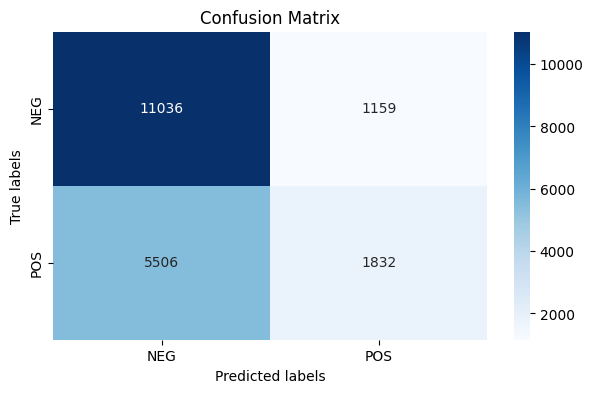

In [ ]:
# Generating the confusion matrix
LABELS = ['NEG','POS']
conf_matrix = confusion_matrix(Y_test, Y_pred_updated, labels=LABELS)
# Plotting the confusion matrix
plt.figure(figsize=(7,4))
sb.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues',xticklabels=LABELS, yticklabels=LABELS)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Data Preprocessing: Normalization

Normalization is a technique applied as a part of data preprocessing to standardize the range of features of data. It is also known as feature scaling. In this lesson, we will explore two common normalization techniques: Min-Max Scaling and Z-Score Standardization.

## 1. Min-Max Scaling

Min-Max Scaling (or Min-Max Normalization) is one of the simplest methods and scales the feature to a fixed range, typically 0 to 1, or -1 to 1. The formula for calculating Min-Max Scaling is:

$$ \text{X}_{\text{norm}} = \frac{X - X_{\text{min}}}{X_{\text{max}} - X_{\text{min}}} $$

### Example
If the range of a feature is from 20 to 80, and the actual value of an observation is 40, it is normalized as follows:
$$ \text{X}_{\text{norm}} = \frac{40 - 20}{80 - 20} = 0.333 $$

## 2. Z-Score Standardization

Z-Score Standardization (or just Standardization) is another common technique that involves rescaling the features so that they’ll have the properties of a standard normal distribution with \( \mu = 0 \) and \( \sigma = 1 \), where \( \mu \) is the mean and \( \sigma \) is the standard deviation from the mean.

The formula for Z-Score Standardization is:

$$ Z = \frac{(X - \mu)}{\sigma} $$

### Example
If the mean of a feature is 50 and the standard deviation is 10, and the actual value of an observation is 60, it is standardized as follows:
$$ Z = \frac{(60 - 50)}{10} = 1.0 $$

These normalization methods are essential, especially in algorithms that are sensitive to the magnitude of values and require normalization as a preprocessing step, such as k-nearest neighbors (KNN) and gradient descent based algorithms like linear regression.


In [ ]:
# Update feature selection based on the analysis above
X_updated = mask.drop('CLASIFFICATION_FINAL', axis=1)
Y = mask['CLASIFFICATION_FINAL']

In [ ]:
# Split the updated dataset into training and testing sets
X_train_updated, X_test_updated, Y_train, Y_test = train_test_split(X_updated, Y, test_size=0.2, random_state=42)

# Create a StandardScaler object
scaler = StandardScaler()

# Fit the scaler to the training data and transform it
X_train_updated = scaler.fit_transform(X_train_updated)

# Apply the same transformation to the test data
X_test_updated = scaler.transform(X_test_updated)

# Data Preprocessing: Cross-Validation

**Overview**
- Cross-validation is a resampling procedure used to evaluate machine learning models on a limited data sample. 
- The main goal of cross-validation is: 
    - to flag problems like overfitting or selection bias
    - to give an insight on how the model will generalize to an independent dataset.

**Why Use Cross-Validation?**
- Model Validation: It helps in assessing how well the model will generalize to an independent dataset.
- Tuning Parameters: It aids in selecting the best parameters for the machine learning model.
- Feature Selection: It can help in determining which features are valuable for the model’s prediction.

**Types of Cross-Validation**
- K-Fold Cross-Validation: The dataset is divided into K equal subsets. Each time, one of the K subsets is used as the test set and the other K-1 subsets are put together to form a training set. The process is repeated K times, with each of the K subsets used exactly once as the test data.
- Stratified K-Fold Cross-Validation: Similar to K-fold cross-validation, but in this method, the folds are made by preserving the percentage of samples for each class.
- Leave-One-Out Cross-Validation (LOOCV): A special case of k-fold cross-validation where K equals the number of data points in the dataset. Each learning set is created by taking all the samples except one, the test data set being the sample left out.

<img src = 'cross_validation.png' width ="600" height ="400">

<img src = 'inside_cv.jpg'>

In [ ]:
# Initialize the logistic regression model
model_updated = LogisticRegression(n_jobs=-1)
# Define K-Fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform K-Fold CV to evaluate model
scores = cross_val_score(model_updated, X_train_updated, Y_train, cv=kf, scoring='accuracy')
print(f'Cross-Validation Accuracy Scores: {scores}')
print(f'Mean CV Accuracy: {scores.mean()}')

# Since cross_val_score only evaluates performance, you still need to train your model on the entire training set
model_updated.fit(X_train_updated, Y_train)
# Make predictions on the test set
Y_pred_updated = model_updated.predict(X_test_updated)
# Evaluate the model on the test set
accuracy_updated = accuracy_score(Y_test, Y_pred_updated)
report_updated = classification_report(Y_test, Y_pred_updated)  # Actual Y and the predicted (Y_hat)
print(report_updated)


Cross-Validation Accuracy Scores: [0.66061071 0.66039023 0.6619469  0.66233074 0.65505917]
Mean CV Accuracy: 0.6600675525718602
              precision    recall  f1-score   support

         NEG       0.66      0.91      0.77     36368
         POS       0.63      0.25      0.36     22252

    accuracy                           0.66     58620
   macro avg       0.65      0.58      0.56     58620
weighted avg       0.65      0.66      0.61     58620



In [ ]:
from sklearn.neighbors import KNeighborsClassifier
# Initialize the logistic regression model
#model_updated = LogisticRegression(n_jobs=-1)
model_updated = KNeighborsClassifier(n_neighbors = 3)
# Define K-Fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
# Perform K-Fold CV to evaluate model
scores = cross_val_score(model_updated, X_train_updated, Y_train, cv=kf, scoring='accuracy')
print(f'Cross-Validation Accuracy Scores: {scores}')
print(f'Mean CV Accuracy: {scores.mean()}')

# Since cross_val_score only evaluates performance, you still need to train your model on the entire training set
model_updated.fit(X_train_updated, Y_train)
# Make predictions on the test set
Y_pred_updated = model_updated.predict(X_test_updated)
# Evaluate the model on the test set
accuracy_updated = accuracy_score(Y_test, Y_pred_updated)
report_updated = classification_report(Y_test, Y_pred_updated)  # Actual Y and the predicted (Y_hat)
print(report_updated)


**Conclusion and Findings**
- After implementing the cross-validation technique of k-folds on k=5, we can conclude that:
    - Cross-Validation accuracy scores across the different folds of cross-validation are relatively consistent, with scores ranging from approximately 0.654 to 0.660. 
    - This indicates that the model is fairly stable and is generalizing well across different subsets of the data.

- **Notes**
    - Underfitting is found when the cross-validation scores are uniformly low
    - while overfitting is detected when the scores vary.

# Data Preprocessing: Regularization

- Regularization is a technique used in machine learning and statistics to prevent overfitting by penalizing large coefficients in a model. 
- Overfitting occurs when a model learns the detail and noise in the training data to the extent that it negatively impacts the performance of the model on new data. 
- Regularization techniques add a penalty on the size of the coefficients to the loss function. 
- Common types of regularization include L1 regularization (Lasso), L2 regularization (Ridge), and Elastic Net, which is a combination of L1 and L2 regularization.

## Mathematical Background

Regularization is a fundamental technique in machine learning designed to prevent overfitting and improve model generalization. This is achieved by adding a penalty term to the loss function, which discourages overly complex models by penalizing large coefficients. The general form of a regularized loss function is:

$$ \text{Loss}_{\text{regularized}} = \text{Loss}_{\text{original}} + \lambda \times \text{Penalty} $$

Here, $\text{Loss}_{\text{original}}$ represents the original loss function, such as Mean Squared Error (MSE) for regression tasks. The parameter $\lambda \geq 0$ is known as the regularization strength; higher values of $\lambda$ apply a stronger penalty, thus encouraging simpler models. The $\text{Penalty}$ term is responsible for imposing costs on the size of coefficients, and its form varies depending on the type of regularization applied.

### L1 Regularization (Lasso)

L1 regularization, also known as Lasso (Least Absolute Shrinkage and Selection Operator), imposes a penalty equal to the absolute value of the magnitude of coefficients. This can be mathematically represented as:

$$ \text{Penalty}_{L1} = \sum_{i=1}^{n} |w_i| $$

where $w_i$ are the model coefficients. L1 regularization tends to produce sparse models, where a subset of coefficients can become exactly zero. This property makes Lasso regularization particularly useful for feature selection in models with high-dimensional data.

### L2 Regularization (Ridge)

L2 regularization, known as Ridge regression, applies a penalty equal to the square of the magnitude of coefficients:

$$ \text{Penalty}_{L2} = \sum_{i=1}^{n} w_i^2 $$

This form of regularization tends to distribute the penalty among all coefficients, pushing them closer to zero but rarely to zero. Unlike L1 regularization, L2 does not naturally result in feature selection but is effective in handling multicollinearity (when independent variables are highly correlated) by distributing the coefficient values across similar features.

### Key Differences between L1 and L2 Regularization

The core difference between L1 and L2 regularization lies in their penalty terms and the resulting impact on the model coefficients:

- **Sparsity**: L1 regularization can produce sparse models, making it a natural choice for feature selection. L2 regularization does not induce sparsity but can shrink the coefficients more uniformly.
- **Solution Path**: The solution path of L1 regularization is piecewise linear, which can lead to models where some coefficients are exactly zero if the regularization strength is sufficiently high. L2 regularization ensures coefficients approach zero asymptotically.
- **Robustness and Stability**: L1 is more robust to outliers than L2 because it penalizes the absolute value of coefficients, leading to smaller and more robust coefficients. However, L2 is more stable in terms of the numerical solution, especially when dealing with multicollinearity.

### Elastic Net

Elastic Net is a hybrid regularization technique that combines the penalties of L1 and L2 regularization:

$$ \text{Penalty}_{\text{ElasticNet}} = \rho \sum_{i=1}^{n} |w_i| + (1 - \rho) \sum_{i=1}^{n} w_i^2 $$

Here, $\rho$ is the mixing parameter that controls the balance between L1 and L2 regularization penalties. Elastic Net is particularly useful when there are multiple features correlated with each other. It combines the feature selection capability of L1 with the regularization strength of L2, making it a versatile choice for various modeling scenarios.


In [ ]:
def APPLY_REGULARIZATION(reg):
    # Fit the regularization model
    reg.fit(X_train_updated, Y_train.map({'NEG':0,'POS':1}))
    # Find the alpha and the score
    print("Best alpha using built-in {}: %f".format(str(reg).split('.')[-1]) % reg.alpha_)
    print("Best score using built-in {}: %f".format(str(reg).split('.')[-1]) %reg.score(X_train_updated,Y_train.map({'NEG':0,'POS':1})))
    coef = pd.Series(reg.coef_, index = X_updated.columns)
    print("{} picked ".format(str(reg).split('.')[-1]) + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")
    imp_coef = coef.sort_values()
    print(imp_coef)
# Initialize regularization and apply
APPLY_REGULARIZATION(ElasticNetCV()) # L1 + L2 Type
APPLY_REGULARIZATION(RidgeCV()) # L2 Type
APPLY_REGULARIZATION(LassoCV()) # L1 Type

Best alpha using built-in ElasticNetCV(): 0.002471
Best score using built-in ElasticNetCV(): 0.057068
ElasticNetCV() picked 12 variables and eliminated the other 4 variables
PNEUMONIA        -0.136976
OBESITY          -0.057718
DIABETES         -0.014472
MEDICAL_UNIT     -0.003682
COPD              0.000000
ASTHMA            0.000000
HIPERTENSION     -0.000000
RENAL_CHRONIC     0.000000
AGE               0.002679
USMER             0.005431
INMSUPR           0.006267
CARDIOVASCULAR    0.008793
OTHER_DISEASE     0.022971
SEX               0.031848
TOBACCO           0.039423
PATIENT_TYPE      0.096794
dtype: float64
Best alpha using built-in RidgeCV(): 10.000000
Best score using built-in RidgeCV(): 0.059231
RidgeCV() picked 16 variables and eliminated the other 0 variables
PNEUMONIA        -0.147046
OBESITY          -0.069028
DIABETES         -0.030460
HIPERTENSION     -0.005046
MEDICAL_UNIT     -0.003955
AGE               0.002610
USMER             0.012516
ASTHMA            0.022855
SEX

**Conclusion:**
- After applying the regularization technique that has the ability to do feature selection such as (LASSO and ELASTICNET) L1s, based on the coefficient of each feature we conclude that:
    - The ASTHMA and the HIPERTENSION can be dropped since their coefficients are 0.
    - Next step is to re-apply the algorithms of ML after dropping the RENAL_CHRONIC, COPD, ASTHMA and the HIPERTENSION

In [ ]:
to_drop = ['RENAL_CHRONIC','COPD','ASTHMA','HIPERTENSION']
# Split the updated dataset into training and testing sets
X_train_updated, X_test_updated, Y_train, Y_test = train_test_split(X_updated.drop(to_drop,axis=1), Y, test_size=0.2, random_state=42)

# Create a StandardScaler object
scaler = StandardScaler()

# Fit the scaler to the training data and transform it
X_train_updated = scaler.fit_transform(X_train_updated)

# Apply the same transformation to the test data
X_test_updated = scaler.transform(X_test_updated)

# Initialize the logistic regression model
model_updated = LogisticRegression(n_jobs=-1)
model_updated.fit(X_train_updated, Y_train)
# Make predictions on the test set
Y_pred_updated = model_updated.predict(X_test_updated)
# Evaluate the model on the test set
accuracy_updated = accuracy_score(Y_test, Y_pred_updated)
report_updated = classification_report(Y_test, Y_pred_updated)  # Actual Y and the predicted (Y_hat)
print(report_updated)


              precision    recall  f1-score   support

         NEG       0.66      0.91      0.77     60475
         POS       0.63      0.25      0.36     37234

    accuracy                           0.66     97709
   macro avg       0.65      0.58      0.56     97709
weighted avg       0.65      0.66      0.61     97709



- Adropping the ASTHMA and the HIPERTENSION, we can notice that the accuracy, precision and recall are unchanged.
- Threfore, they have no effect on classification as the regularization showed.

# K-Nearest Neighbor (KNN)

K-Nearest Neighbors (KNN) is a simple, yet powerful machine learning algorithm used for both classification and regression tasks. Unlike logistic regression, which is a predictive modeling technique based on the assumption of a mathematical relationship between input variables and the probability of the target variable, KNN works by finding the most similar historical data points to the new data point and predicting the outcome based on the outcomes of these neighbors.

**Input:**
- Predictor Variables (Features): KNN uses predictor variables (X) similar to logistic regression. These variables describe the characteristics of the data points. The algorithm uses these features to find the nearest neighbors of a new data point.
- Target Variable (Label): The target variable (Y) in KNN can be either categorical for classification tasks or continuous for regression tasks. For classification, the algorithm assigns a class to the new data point based on the majority vote of its nearest neighbors.

**Output:**
- Class Membership (for classification): In classification tasks, KNN outputs the class with the majority vote among the K nearest neighbors of the new data point.
- Value Prediction (for regression): In regression tasks, KNN predicts the value for the new data point based on the average (or another aggregate measure) of the values of its K nearest neighbors.

**How It Works:**
- Choosing K: The first step in KNN is to choose the number of neighbors (K). This is a crucial parameter that influences the performance of the algorithm. A small value of K can make the algorithm sensitive to noise in the data, while a large value makes it computationally expensive and may lead to underfitting.
- Distance Measure: To find the nearest neighbors, KNN calculates the distance between data points using a distance measure such as Euclidean, Manhattan, or Minkowski distance. The choice of distance measure can affect the performance of the algorithm.
- Finding Nearest Neighbors: For each new data point, the algorithm searches the training dataset to find the K nearest neighbors based on the distance measure.

- Majority Vote or Averaging:

    - Classification: For classification tasks, KNN assigns the class based on the majority class among the K nearest neighbors. Ties can be broken randomly or by reducing K until a clear majority is found.
    - Regression: For regression tasks, KNN predicts the value by averaging (or taking another aggregate measure) the values of the K nearest neighbors.
- Prediction: The new data point is assigned the computed class (for classification) or value (for regression) based on its nearest neighbors.

KNN is widely appreciated for its simplicity, ease of understanding, and effectiveness in many scenarios. However, it can be computationally expensive as it requires storing the entire dataset and calculating distances between data points for each prediction. Additionally, the performance of KNN can be significantly impacted by the choice of K and the distance measure used.

## Continue Preprocessing before applying KNN

- First let's do better data preprocessing after the Cross-Validation and Regularization
    - Removing irrelevant data
        - I found that 
            - USMER and MEDICAL_UNIT are irrelevant to classification task so we will remove it. 

In [ ]:
# Initialize the KNN
model_updated = KNN(10)
model_updated.fit(X_train_updated, Y_train)
# Make predictions on the test set
Y_pred_updated = model_updated.predict(X_test_updated)
# Evaluate the model on the test set
accuracy_updated = accuracy_score(Y_test, Y_pred_updated)
report_updated = classification_report(Y_test, Y_pred_updated)  # Actual Y and the predicted (Y_hat)
print(report_updated)

- KNN is not efficient when handling large number of records or large data

### REAPPLY logistic Regression to compare results with KNN

In [ ]:
# Initialize the logistic regression model
model_updated = LogisticRegression(n_jobs=-1)
model_updated.fit(X_train_updated, Y_train)
# Make predictions on the test set
Y_pred_updated = model_updated.predict(X_test_updated)
# Evaluate the model on the test set
accuracy_updated = accuracy_score(Y_test, Y_pred_updated)
report_updated = classification_report(Y_test, Y_pred_updated)  # Actual Y and the predicted (Y_hat)
print(report_updated)

- The KKN didn't perform well as expected, this is because of the dataset structure, the accuracy went to 62% in KNN while the Logistic Regression is kept 66%. Even after dropping the USMER and MEDICAL_UNIT which proves that the USMER and MEDICAL_UNIT are not effective features too. Therefore, they can be dropped. Also keep in mind the time taken in KNN is too much compared to logistic regression since the KNN is not well suited for large datasets 

# Decision Tree and Random Forests

Decision Trees are versatile machine learning algorithms that can be used for both classification and regression tasks. Unlike models that make predictions based on a linear assumption of the relationship between input variables, Decision Trees make predictions by learning simple decision rules inferred from the data features.

**Input:**
- Predictor Variables (Features): Similar to other machine learning algorithms, Decision Trees use predictor variables (X) to make decisions. These variables describe the characteristics of the data points and are used by the tree to split the data into subsets.
- Target Variable (Label): The target variable (Y) can be either categorical for classification tasks or continuous for regression tasks. Decision Trees make their predictions based on the values of the target variable in the leaf nodes.

**Output:**
- Class Membership (for classification): In classification tasks, Decision Trees output the class that is most frequent among the instances in the leaf node reached by the new data point.
- Value Prediction (for regression): In regression tasks, Decision Trees predict the value for the new data point based on the average value of the instances in the leaf node it falls into.

**How It Works:**
- Node Splitting: At each node in the tree, the algorithm selects the best predictor variable and splits its value in a way that results in the most significant increase in homogeneity for the target variable in the resulting subsets. The "best" split is determined based on a criterion such as Gini impurity for classification or variance reduction for regression.
- Tree Building: The process of node splitting continues recursively, creating a tree structure, until a stopping criterion is met. This criterion could be a maximum depth of the tree, a minimum number of samples required to split a node, or a minimum number of samples required for a leaf node, among others.
- Pruning: To prevent overfitting, trees are often pruned. Pruning involves cutting back parts of the tree (removing subtrees) to improve its generalization to unseen data. There are several approaches to pruning, such as cost complexity pruning.
- Decision Making:
    - Classification: For classification tasks, a decision tree assigns a class to a new data point based on the majority class in the leaf node that the data point falls into.
    - Regression: For regression tasks, a decision tree predicts the value for a new data point based on the average (or another aggregate measure) of the target variable for the instances in the leaf node it falls into.
- Prediction: Once the tree is built (and possibly pruned), it can be used to make predictions. The new data point is passed down the tree until it reaches a leaf node. The prediction is then based on the output defined for that leaf node.

**Advantages of Decision Trees:**
- Decision Trees are easy to understand and interpret, making them attractive for operational use.
- They require little data preparation compared to many other algorithms (e.g., no need for feature scaling).
- The tree structure allows for the handling of both numerical and categorical data.

**Disadvantages of Decision Trees:**
- They are prone to overfitting, especially with complex trees. Pruning and setting the maximum depth of the tree are common ways to address this issue.
- Decision Trees can be unstable because small variations in the data might result in a completely different tree being generated. This problem is mitigated by using ensemble methods like Random Forests.
- They can create biased trees if some classes dominate. It's often recommended to balance the dataset before training a Decision Tree.

Decision Trees are a fundamental component of many ensemble methods, such as Random Forests and Gradient Boosting Machines, which combine the predictions of multiple trees to improve prediction accuracy and robustness.


In [ ]:
# Initialize the decision tree
model_updated = DecisionTreeClassifier()
model_updated.fit(X_train_updated, Y_train)
# Make predictions on the test set
Y_pred_updated = model_updated.predict(X_test_updated)
# Evaluate the model on the test set
accuracy_updated = accuracy_score(Y_test, Y_pred_updated)
report_updated = classification_report(Y_test, Y_pred_updated)  # Actual Y and the predicted (Y_hat)
print(report_updated)

**Random Forest**:
- Expecting the Random Forest to perform equal or better than the decision tree

<img src = 'random-forest.jpg' width = 600>

In [ ]:
# Initialize RF
model_updated = RandomForestClassifier(n_estimators = 10)
model_updated.fit(X_train_updated, Y_train)
# Predict function
Y_pred_updated = model_updated.predict(X_test_updated)
# Evaluation of model
accuracy_updated = accuracy_score(Y_test, Y_pred_updated)
report_updated = classification_report(Y_test, Y_pred_updated)  # Actual Y and the predicted (Y_hat)
print(report_updated)

**Note:**
- Random forest performed same as decision tree

# Assignment

- Apply the random forset algorithm with best hyperparameters!
    - Note: You can use GridSearch

Best Parameters: {'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 60}

# Asynchronous Functionalities

<img src = 'parralel_comp.png'>

import dill
dill.load_session('4may2024.db')

**1. Multithreading Using ThreadPoolExecutor**

- I/O-Bound Tasks: If your tasks involve a lot of waiting for I/O operations (such as reading from disk or network operations), ThreadPoolExecutor can be very effective. 
- Threads are lightweight and managed within a single process, which allows you to perform multiple I/O operations in parallel without consuming much in terms of CPU resources.
- Integration with asyncio: If you are using asyncio for asynchronous programming, threading can be integrated more seamlessly compared to using multiple processes.
- Simplicity: Using ThreadPoolExecutor can be simpler when you want to parallelize tasks that don't require heavy CPU usage or when the libraries you use release the Python GIL during intensive computations.

In [ ]:
from concurrent.futures import ThreadPoolExecutor

In [ ]:
# Function to train a model and measure performance
def train_model(model, model_name, X_train, Y_train, X_test, Y_test):
    start_time = time.time() # Timer start
    model.fit(X_train[:30000], Y_train[:30000]) # Fitting (for simplicity 30000)
    Y_pred = model.predict(X_test[:10000]) # Predicting (for simplicity 10000)
    accuracy = accuracy_score(Y_test[:10000], Y_pred)
    elapsed_time = time.time() - start_time # ET now - start_time
    return model_name, accuracy, elapsed_time

# Asynchronous execution of model training
def async_train_models(X_train, Y_train, X_test, Y_test):
    models = [
        (KNN(), "KNN"),
        (DecisionTreeClassifier(), "Decision Tree"),
        (RandomForestClassifier(), "Random Forest"),
        (LogisticRegression(), "Logistic Regression")
    ]
    with ThreadPoolExecutor(max_workers=len(models)) as executor:
        futures = [executor.submit(train_model, model, name, X_train, Y_train, X_test, Y_test) for model, name in models]
        for future in futures:
            model_name, accuracy, time_taken = future.result()
            print(f"{model_name}: Accuracy = {accuracy:.2f}, Time = {time_taken:.2f} seconds")

# Call the function
async_train_models(X_train_updated, Y_train, X_test_updated, Y_test)

**2. Multiprocessing Using joblib**

- CPU-Bound Tasks: For tasks that are CPU-intensive, such as training different machine learning models, joblib is generally superior because it can efficiently parallelize these tasks across multiple cores and even multiple machines. 
- joblib is particularly optimized for these kinds of jobs and is frequently used in scientific computing and data processing tasks.
- Memory Management: joblib also has optimizations for memory management when duplicating data across processes. It can avoid copying all data in memory for each process, using shared memory for large numpy arrays.
- Scikit-learn Integration: joblib is tightly integrated with scikit-learn, meaning many of its functions and models support joblib for parallel processing out-of-the-box. This makes it an excellent choice for machine learning workflows.

In [ ]:
from joblib import Parallel, delayed

In [ ]:
# Function to train a model and measure performance
def train_model(model, model_name, X_train, Y_train, X_test, Y_test):
    start_time = time.time()
    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)
    accuracy = accuracy_score(Y_test, Y_pred)
    elapsed_time = time.time() - start_time
    return model_name, accuracy, elapsed_time
# Asynchronous execution of model training
def async_train_models(X_train, Y_train, X_test, Y_test):
    models = [
        (KNN(), "KNN"),
        (DecisionTreeClassifier(), "Decision Tree"),
        (RandomForestClassifier(), "Random Forest"),
        (LogisticRegression(), "Logistic Regression")
    ]
    results = Parallel(n_jobs=len(models))(delayed(train_model)(model, name, X_train[:30000], Y_train[:30000], X_test[:10000], Y_test[:10000]) for model, name in models)
    for result in results:
        model_name, accuracy, time_taken = result
        print(f"{model_name}: Accuracy = {accuracy:.2f}, Time = {time_taken:.2f} seconds")
        
async_train_models(X_train_updated, Y_train, X_test_updated, Y_test)


Performance:
- For CPU-bound tasks like training machine learning models, joblib will usually provide better performance than ThreadPoolExecutor because:

- Concurrency Model: joblib uses processes instead of threads. This avoids issues with the Global Interpreter Lock (GIL) that can hinder performance in multi-threaded, CPU-bound applications. Processes allow full parallel execution on multiple CPU cores.
- Efficient Use of CPUs: By spreading tasks across different cores, joblib ensures that each process is running in true parallel, thus maximizing CPU utilization.

Conclusion:
- If the task is CPU-intensive and involves data-intensive computations typical of model training scenarios, joblib is generally the better choice. It is optimized for such use cases and can efficiently use all available CPU resources.

- On the other hand, if the tasks are more I/O-bound or involve significant asynchronous operations, ThreadPoolExecutor might be more appropriate due to its lightweight nature and easier integration with asynchronous I/O operations.